In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [38]:
r = {
    'TS': [0.02, 0.2, -65, 6],
    'PS': [0.02, 0.25, -65, 6],
    'C': [0.02, 0.2, -50, 2],
    'FS': [0.1, 0.2, -65, 2]
}
a = r['TS'][0]
b = r['TS'][1]
c = r['TS'][2]
d = r['TS'][3]

In [39]:
I = 5
h = 0.5

def f1(u, v):
    return 0.04*(v**2) + 5*v + 140 - u + I

def f2(u, v):
    return a*(b*v - u)

In [40]:
def euler(t0, tn, f, h):
    m = int((tn-t0)/h)
    v = np.zeros(m+1)
    u = np.zeros(m+1)
    v[0] = c
    u[0] = b*v[0]
    for i in range(m):
        v[i+1] = v[i] + h * f[0](u[i], v[i])
        u[i+1] = u[i] + h * f[1](u[i], v[i])
        if v[i+1] >= 30:
            v[i+1] = c
            u[i+1] = u[i+1] + d
    return u,v

In [62]:
def implicit_euler(t0, tn, f, h):
    m = int((tn-t0)/h)
    v = np.zeros(m+1)
    u = np.zeros(m+1)
    v[0] = c
    u[0] = b*v[0]
    def phiV(v1, u0, v0):
        return v1 - h*f[0](u0, v1) - v0 
    def phiU(u1, u0, v0):
        return u1  - h*f[1](u1, v0) - u0
    for i in range(0, m):
        v[i+1] = optimize.root(phiV, v[i], args=(u[i], v[i])).x
        u[i+1] = optimize.root(phiU, u[i], args=(u[i], v[i])).x
        if v[i+1] >= 30:
            v[i+1] = c
            u[i+1] = u[i+1] + d
    return u,v

In [63]:
def runge_kutta(t0, tn, f, h):
    m = int((tn-t0)/h)
    v = np.zeros(m+1)
    u = np.zeros(m+1)
    v[0] = c
    u[0] = b*v[0]
    for i in range(m):
        kv1 = h*f[0](u[i], v[i])
        ku1 = h*f[1](u[i], v[i])
        kv2 = h*f[0](u[i] + h/2, v[i] + kv1/2)
        ku2 = h*f[1](u[i] + ku1/2, v[i] + h/2)
        kv3 = h*f[0](u[i] + h/2, v[i] + kv2/2)
        ku3 = h*f[1](u[i] + ku2/2, v[i] + h/2)
        kv4 = h*f[0](u[i] + h, v[i] + kv3)
        ku4 = h*f[1](u[i] + ku3, v[i] + h)
        v[i+1] = v[i] + (kv1 + 2*kv2 + 2*kv3 + kv4)/6
        u[i+1] = u[i] + (ku1 + 2*ku2 + 2*ku3 + ku4)/6
        if v[i+1] >= 30:
            v[i+1] = c
            u[i+1] += d
    return u,v

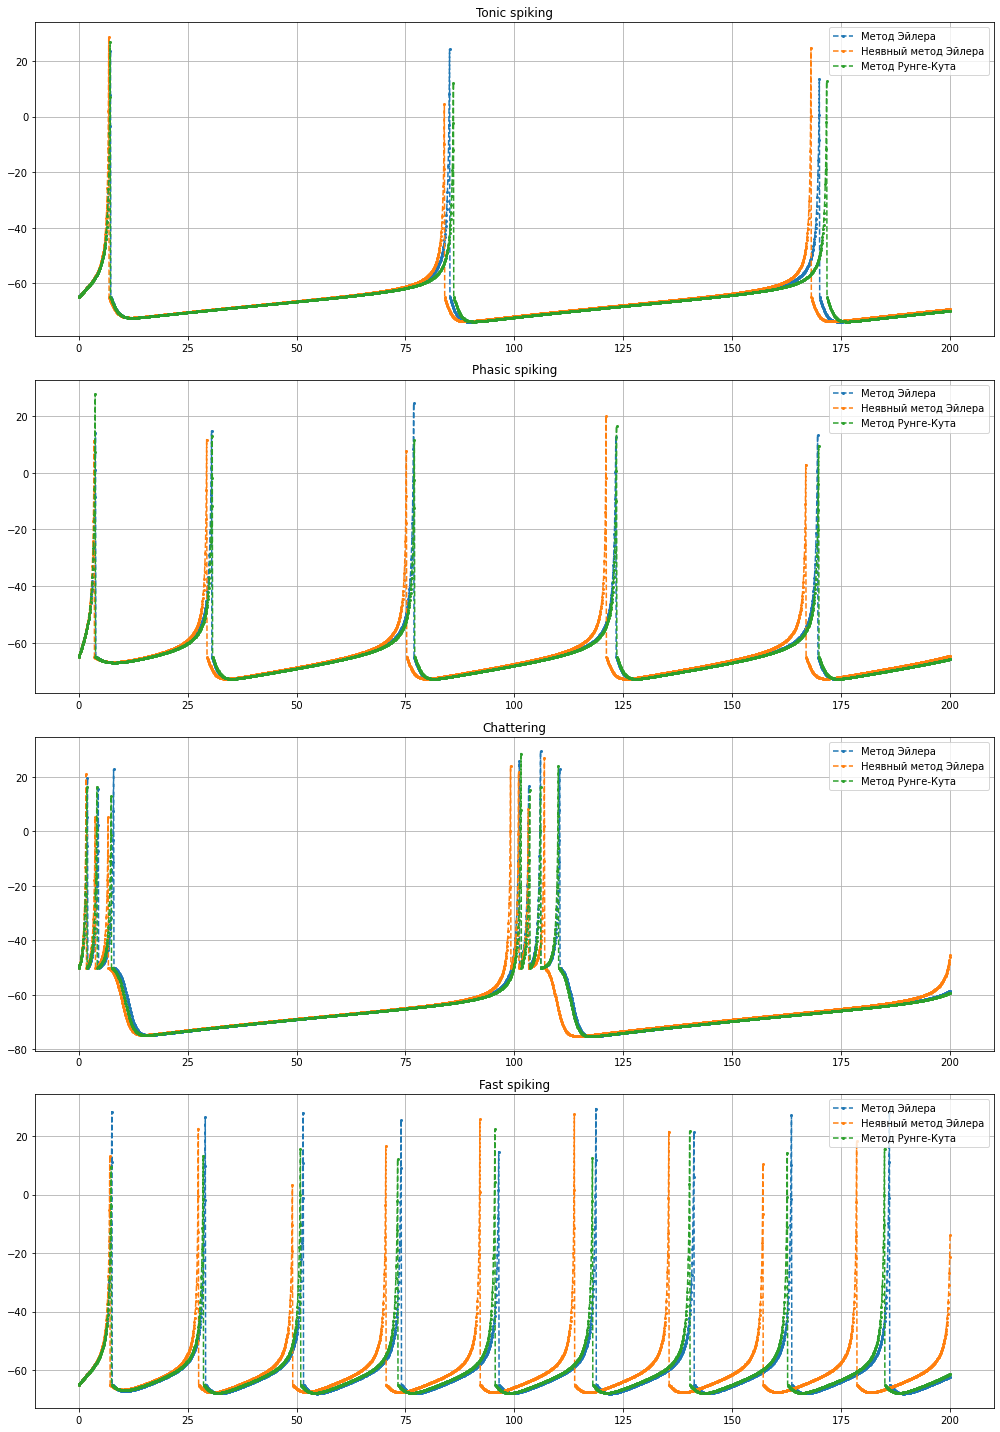

In [79]:
t0 = 0
tn = 200
h = 0.08
t = np.linspace(t0, tn, int((tn-t0)/h) + 1)

fig, ax = plt.subplots(4, 1, figsize=(14,20))
names = ['Tonic spiking', 'Phasic spiking', 'Chattering', 'Fast spiking']
for i, j, ax_ in zip(['TS', 'PS', 'C', 'FS'], names, ax):
    a = r[i][0]
    b = r[i][1]
    c = r[i][2]
    d = r[i][3]
    
    u1, v1 = euler(t0, tn, [f1, f2], h)
    u2, v2 = implicit_euler(t0, tn, [f1, f2], h)
    u3, v3 = runge_kutta(t0, tn, [f1, f2], h)
    
    ax_.set_title(j, loc='center')
    ax_.plot(t, v1, 'o--', label = r'Метод Эйлера', markersize = 2)
    ax_.plot(t, v2, 'o--', label = r'Неявный метод Эйлера', markersize = 2)
    ax_.plot(t, v3, 'o--', label = r'Метод Рунге-Кута', markersize = 2)
    
    ax_.grid()
    plt.tight_layout()
    ax_.legend()
plt.show()

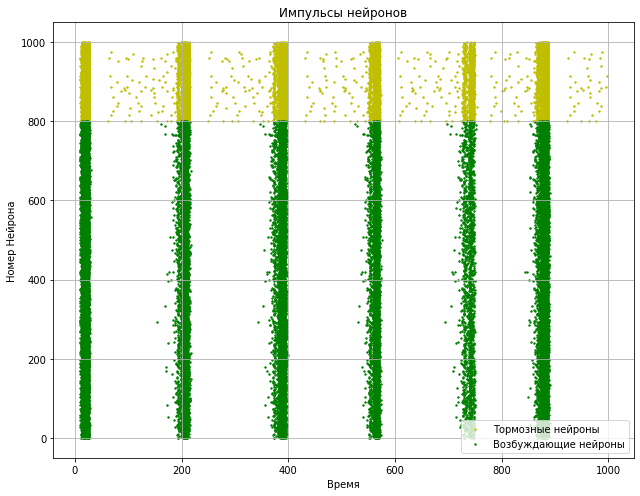

In [98]:
h = 0.5
tn = 1000
n = 1000
nBrake = int(n*.2)
nExciting = int(n*.8)

alf = np.random.default_rng().random(nExciting)
bet = np.random.default_rng().random(nExciting) 
ksi = np.random.default_rng().random(nExciting)

gam = np.random.default_rng().random(nBrake)
dlt = np.random.default_rng().random(nBrake)
dze = np.random.default_rng().random(nBrake)

tet = np.random.default_rng().random((n, nExciting))
tau = np.random.default_rng().random((n, nBrake))

W = np.hstack((.5*tet ,- tau))


a = np.hstack((.02*np.ones(nExciting), .02 + .08*gam))
b = np.hstack((.2*np.ones(nExciting), .25 - .05*dlt))
c = np.hstack((-65 + 15*alf**2, -65*np.ones(nBrake)))
d = np.hstack((8 - 6*bet**2, 2*np.ones(nBrake)))

nExcitingTime = []
nExcitingID = []

nBrakeTime = []
nBrakeID = []


v = -65*np.ones(n)
u = v*b

I = np.hstack((5*ksi, 2*dze))

for t in range(tn):
    IMP = v >= 30
    
    
    for i, detectIMP in zip(np.arange(len(IMP)),IMP):
        if detectIMP: 
            if i>nExciting-1:
                nBrakeTime.append(t)
                nBrakeID.append(i)
            else:
                nExcitingTime.append(t)
                nExcitingID.append(i)

    v[IMP] = c[IMP]
    u[IMP] = u[IMP] + d[IMP]

    INext = I.copy()
    INext += np.sum(W[:, IMP], axis=1)

    for i in range(2):
        vNext = v + h*(.04*v**2 + 5*v + 140 - u + INext)
        uNext = u + h*a*(b*v - u)
        v = vNext
        u = uNext

plt.figure(figsize=(9,7))
plt.scatter(nBrakeTime, nBrakeID, color="y", label="Тормозные нейроны", s=2)
plt.scatter(nExcitingTime, nExcitingID, color="g", label="Возбуждающие нейроны", s=2)
plt.title("Импульсы нейронов")
plt.xlabel('Время')
plt.ylabel('Номер Нейрона')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()